<a href="https://colab.research.google.com/github/gtsagkatakis/CNN_lightcurve/blob/main/CNN_for_LC_March2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First you need to import your Google drive where data are located

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries and define a plotting function

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 16 15:05:46 2018

@author: Grigorios Tsagkatakis
"""
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import scipy.io as scio
import tensorflow.keras.utils as ult
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import pickle
from sklearn import metrics
import tensorflow as tf


class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.losses2 = []
        self.val_losses2 = []
        
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.losses2.append(logs.get('categorical_accuracy'))
        self.val_losses2.append(logs.get('val_categorical_accuracy'))

        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses2, label="Training accuracy",linestyle='-')
        plt.plot(self.x, self.val_losses2, label="Validataion accuracy",linestyle='--')
        plt.ylim(0,1)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.savefig('acc_running.png',dpi=300)
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, label="Training loss",linestyle='-')
        plt.plot(self.x, self.val_losses, label="Validataion loss",linestyle='--')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        
        plt.savefig('loss_running.png',dpi=300)
        
        plt.show();
        


Load data for training and validataion

In [ ]:
       
plot_losses = PlotLosses()

plt.close('all')

mat = scio.loadmat('/content/drive/MyDrive/CNN_LightCurveProject/lc_50000examples_train_n_validate.mat')

data=mat.get('data')
labels=mat.get('labels')

[n1,n2]=data.shape

data=data.reshape(n1, n2, 1)

num_train=  45000 
num_val =   5000

train_data=data[0:num_train,:,:]
val_data=data[num_train:num_train+num_val,:,:]

train_labels=labels[0:num_train]
val_labels=labels[num_train:num_train+num_val]

num_classes=10

train_labels_1hot=ult.to_categorical(train_labels,num_classes=num_classes)
val_labels_1hot=ult.to_categorical(val_labels,num_classes=num_classes)


Define deep learning model

In [ ]:

def layer_group(x):
    conv00  = Conv1D(32, (10), activation='relu', dilation_rate=1, padding='same')(x)
    conv01  = Conv1D(32, (20), activation='relu', dilation_rate=1, padding='same')(conv00)
    conv02  = Conv1D(32, (50), activation='relu', dilation_rate=1, padding='same')(conv01)
    add0 = Add()([x,conv02])
    pool00  = MaxPooling1D(pool_size=(3), strides=(2), padding='same')(add0)
    bn1 = BatchNormalization()(pool00)
    return bn1  
    

inputs = Input(( n2, 1),name='main_input')

conv00  = Conv1D(32, (1), activation='linear', dilation_rate=1, padding='same')(inputs)

l1=layer_group(conv00)
l2=layer_group(l1)
l3=layer_group(l2)
l4=layer_group(l3)
l5=layer_group(l4)

fl0 = Flatten(name='fl0')(l5)

fc0     = Dense(128,activation='linear', kernel_regularizer=regularizers.l2(0.1))(fl0)
Do0     = Dropout(0.75)(fc0) 
fc1     = Dense(32,activation='linear', kernel_regularizer=regularizers.l2(0.1))(Do0)
Do1     = Dropout(0.75)(fc1) 
Dn0     = Dense(num_classes,activation='softmax')(Do1)


model_1 = Model(inputs=[inputs], outputs=[Dn0])
optzr =  Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, decay=1e-5)

model_1.compile(loss='categorical_crossentropy',optimizer=optzr, metrics =['categorical_accuracy'])


(Optional) Train model on data

In [ ]:
history=model_1.fit(train_data,[train_labels_1hot], batch_size=100, epochs=5,validation_data=[val_data,val_labels_1hot],callbacks=[plot_losses],shuffle=True)
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Load trained model


In [ ]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/CNN_LightCurveProject/full_model_45000training_500epochs.h5')


Report performance on validataion set

In [ ]:
res=model_1.evaluate([val_data],[val_labels_1hot])
print(res)

 69/157 [============>.................] - ETA: 23s - loss: 0.1177 - categorical_accuracy: 0.9964

KeyboardInterrupt: ignored

(Optinal) plot training history

In [ ]:
   
g=pickle.load(open('/content/drive/MyDrive/CNN_LightCurveProject/trainHistoryDict','rb'))

A=model_1.history.history
B1=A.get('categorical_accuracy')
C1=np.asarray(B1)
B2=A.get('val_categorical_accuracy')
C2=np.asarray(B2)


plt.plot(C1,label="Training accuracy",linestyle='-')
plt.plot(C2,label="Validataion accuracy",linestyle='--')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.ylabel('Categorical accuracy')
plt.savefig('acc_0.png',dpi=300)
plt.show()


A=model_1.history.history
B1=A.get('loss')
C1=np.asarray(B1)
B2=A.get('val_loss')
C2=np.asarray(B2)

plt.plot(C1,label="Training loss ",linestyle='-')
plt.plot(C2,label="validataion loss ",linestyle='--')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Categorical crossentropy')
plt.savefig('loss_0.png',dpi=300)
plt.show()


FileNotFoundError: ignored

Load testing data

In [ ]:

mat = scio.loadmat('/content/drive/MyDrive/CNN_LightCurveProject/lc_50000examples_testset.mat')

data=mat.get('data')
labels=mat.get('labels')

[n1,n2]=data.shape

data=data.reshape(n1, n2, 1)

num_test=  1000 

test_data=data[0:num_test,:,:]
test_labels=labels[0:num_test]

num_classes=10

test_labels_1hot=ult.to_categorical(test_labels,num_classes=num_classes)


In [ ]:
res=model_1.evaluate(test_data,test_labels_1hot,batch_size=100)
print(res)

10/10 [==============================] - 8s 808ms/step - loss: 0.2179 - categorical_accuracy: 0.9660
[0.21785861253738403, 0.9660000205039978]


Evaluate performance on testing data

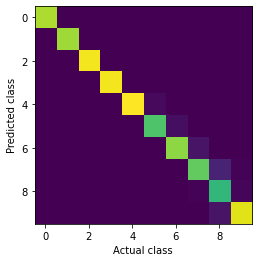

In [ ]:
pred0=model_1.predict(test_data,batch_size=100)
out1_mx=np.argmax(pred0,1)
test_labels_z_mx=np.argmax(test_labels_1hot,1)
cm1=metrics.confusion_matrix(test_labels_z_mx,out1_mx)
plt.figure(0)
plt.imshow(cm1)
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.savefig('cm4.png',dpi=300)